# [실습] LangChain Tool과 Agent


Agent는 사용자의 요청에 대해, 툴(Tool)로 표현되는 외부 모듈을 활용하여 문제를 해결하는 기능입니다.     

Tool은 LLM이 답변을 출력하기 위해 활용할 수 있는 다양한 수단을 의미합니다.   
LLM은 Tool을 사용하기 위해 Tool 이름과 Argument를 생성하는데요.

이 Tool 실행을 자동화하여 LLM을 반복적으로 실행하여 최종 단계에 도달하는 방법이 Agent입니다.

<br><br><br>
Agent의 작동 방식은 아래와 같습니다.

1. 에이전트에 입력이 주어지면, 툴을 사용하는 액션(Action)을 결정합니다.
1. 툴의 사용 결과가 에이전트에 전달되면, 이를 활용하여 다음 액션을 정합니다.
1. 이후, 원하는 결과에 도달할 때까지 반복됩니다.

In [ ]:
!pip install langchain langchain-openai langchain-community langgraph pypdf chromadb wikipedia tavily-python wikipedia matplotlib langchain-experimental
                            

  Obtaining dependency information for pyparsing<3.1,>=2.3.1 from https://files.pythonhosted.org/packages/6c/10/a7d0fa5baea8fe7b50f448ab742f26f52b80bfca85ac2be9d35cdd9a3246/pyparsing-3.0.9-py3-none-any.whl.metadata
INFO: pip is looking at multiple versions of langchain-experimental to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for langchain-experimental from https://files.pythonhosted.org/packages/b2/27/fe8caa4884611286b1f7d6c5cfd76e1fef188faaa946db4fde6daa1cd2cd/langchain_experimental-0.3.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.2.1
    Uninstalling pyparsing-3.2.1:
      Successfully uninstalled pyparsing-3.2.1
  Attempting uninstall: langchain-experimental
    Found existing install

## OpenAI API로 Agent 구현하기

In [1]:
import os
import openai
from dotenv import load_dotenv
from pathlib import Path

env_path = Path("/Users/blueno/UNO/SKALA/SKALA/.env")
load_dotenv(dotenv_path=env_path, override=True)

# 환경 변수 확인
openai_api_key = os.getenv("OPENAI_API_KEY")


client = openai.OpenAI()

Agent는 포맷에 맞는 입/출력의 반복을 통해 문제를 해결합니다.

In [3]:
class Agent:
    # __init__ : Agent 클래스가 생성될 때 호출되는 함수
    def __init__(self, system_prompt=""):
        self.system_prompt = system_prompt
        self.messages = []
        # message를 저장

        self.messages.append({"role": "system", "content": system_prompt})

    # __call__ : Agent 클래스가 호출될 때 호출되는 함수
    # message와 result를 생성하고 이를 messages에 추가
    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    # execute : 현재까지의 message로 답변 생성
    def execute(self):
        completion = client.chat.completions.create(
                        model="gpt-4o-mini",
                        temperature=0,
                        messages=self.messages)
        return completion.choices[0].message.content


In [4]:
prompt = """
당신은 질문에 답변하기 위해 Thought, Action, PAUSE, Observation의 루프를 사용하는 인공지능 비서입니다.
루프의 끝에는 답변을 출력합니다.
질문에 대한 답변을 설명하기 위해 Thought를 사용합니다.
Action을 사용하여 사용 가능한 작업 중 하나를 실행하고 PAUSE를 반환합니다.
Observation은 해당 작업을 실행한 결과입니다.

사용 가능한 작업은 다음과 같습니다:


search_number:
예시) search_number: 전우치
연락처 목록에서 이름을 검색하고 해당 이름의 전화번호를 반환합니다.

send_message:
예시) send_message: 010-1234-5678
전화번호를 사용하여 메시지를 보내고 메시지를 성공적으로 보냈다는 메시지를 반환합니다.

다음은 예시 사용 사례입니다:

Question: 홍길동의 전화번호는 무엇입니까?
Thought: 홍길동의 전화번호를 찾기 위해 search_number 작업을 사용해야 한다.
Action: search_number: 홍길동
PAUSE

그 이후 작업의 결과와 함께 다시 호출됩니다.
Observation은 외부에서 입력되는 메시지입니다. 임의로 생성할 수 없습니다.:

Observation: 010-4539-2918

이제 답변을 출력합니다:

Answer: 홍길동의 전화번호는 010-4539-2918입니다.
"""

In [5]:
def send_message(recipient):
    return recipient+ "에 메시지를 성공적으로 보냈습니다."

def search_number(name):
    if name == '홍길동':
        return("010-4539-2918")
    elif name == '전우치':
        return ("010-1234-5678")
    elif name == '이순신':
        return("010-9876-5432")
known_actions = {
    "send_message": send_message,
    "search_number": search_number
}

In [6]:
abot = Agent(prompt)

In [7]:
result = abot("홍길동의 전화번호는 무엇입니까?")
print(result)

Thought: 홍길동의 전화번호를 찾기 위해 search_number 작업을 사용해야 한다.  
Action: search_number: 홍길동  
PAUSE


In [8]:
result = search_number("홍길동")
result

'010-4539-2918'

In [9]:
next_prompt = "Observation: {}".format(result)
next_prompt

'Observation: 010-4539-2918'

In [10]:
abot(next_prompt)

'Answer: 홍길동의 전화번호는 010-4539-2918입니다.'

In [11]:
abot.messages

[{'role': 'system',
  'content': '\n당신은 질문에 답변하기 위해 Thought, Action, PAUSE, Observation의 루프를 사용하는 인공지능 비서입니다.\n루프의 끝에는 답변을 출력합니다.\n질문에 대한 답변을 설명하기 위해 Thought를 사용합니다.\nAction을 사용하여 사용 가능한 작업 중 하나를 실행하고 PAUSE를 반환합니다.\nObservation은 해당 작업을 실행한 결과입니다.\n\n사용 가능한 작업은 다음과 같습니다:\n\n\nsearch_number:\n예시) search_number: 전우치\n연락처 목록에서 이름을 검색하고 해당 이름의 전화번호를 반환합니다.\n\nsend_message:\n예시) send_message: 010-1234-5678\n전화번호를 사용하여 메시지를 보내고 메시지를 성공적으로 보냈다는 메시지를 반환합니다.\n\n다음은 예시 사용 사례입니다:\n\nQuestion: 홍길동의 전화번호는 무엇입니까?\nThought: 홍길동의 전화번호를 찾기 위해 search_number 작업을 사용해야 한다.\nAction: search_number: 홍길동\nPAUSE\n\n그 이후 작업의 결과와 함께 다시 호출됩니다.\nObservation은 외부에서 입력되는 메시지입니다. 임의로 생성할 수 없습니다.:\n\nObservation: 010-4539-2918\n\n이제 답변을 출력합니다:\n\nAnswer: 홍길동의 전화번호는 010-4539-2918입니다.\n'},
 {'role': 'user', 'content': '홍길동의 전화번호는 무엇입니까?'},
 {'role': 'assistant',
  'content': 'Thought: 홍길동의 전화번호를 찾기 위해 search_number 작업을 사용해야 한다.  \nAction: search_number: 홍길동  \nPAUSE'},
 {'role': 'user', 'content': 'Observation: 010-4539-29

In [12]:
abot = Agent(prompt)
question = """전우치에게 메시지 보내 주세요."""
print(abot(question))

Thought: 전우치에게 메시지를 보내기 위해 먼저 그의 전화번호를 찾아야 한다. 따라서 search_number 작업을 사용해야 한다.  
Action: search_number: 전우치  
PAUSE


In [13]:
next_prompt = "Observation: {}".format(search_number("전우치"))
print(next_prompt)

Observation: 010-1234-5678


In [14]:
print(abot(next_prompt))

Thought: 전우치의 전화번호를 찾았으므로, 이제 이 번호로 메시지를 보내야 한다. send_message 작업을 사용해야 한다.  
Action: send_message: 010-1234-5678  
PAUSE


In [15]:
next_prompt = "Observation: {}".format(send_message("010-1234-5678"))
print(next_prompt)

Observation: 010-1234-5678에 메시지를 성공적으로 보냈습니다.


In [16]:
abot(next_prompt)

'Answer: 전우치에게 메시지를 성공적으로 보냈습니다.'

In [17]:
abot.messages

[{'role': 'system',
  'content': '\n당신은 질문에 답변하기 위해 Thought, Action, PAUSE, Observation의 루프를 사용하는 인공지능 비서입니다.\n루프의 끝에는 답변을 출력합니다.\n질문에 대한 답변을 설명하기 위해 Thought를 사용합니다.\nAction을 사용하여 사용 가능한 작업 중 하나를 실행하고 PAUSE를 반환합니다.\nObservation은 해당 작업을 실행한 결과입니다.\n\n사용 가능한 작업은 다음과 같습니다:\n\n\nsearch_number:\n예시) search_number: 전우치\n연락처 목록에서 이름을 검색하고 해당 이름의 전화번호를 반환합니다.\n\nsend_message:\n예시) send_message: 010-1234-5678\n전화번호를 사용하여 메시지를 보내고 메시지를 성공적으로 보냈다는 메시지를 반환합니다.\n\n다음은 예시 사용 사례입니다:\n\nQuestion: 홍길동의 전화번호는 무엇입니까?\nThought: 홍길동의 전화번호를 찾기 위해 search_number 작업을 사용해야 한다.\nAction: search_number: 홍길동\nPAUSE\n\n그 이후 작업의 결과와 함께 다시 호출됩니다.\nObservation은 외부에서 입력되는 메시지입니다. 임의로 생성할 수 없습니다.:\n\nObservation: 010-4539-2918\n\n이제 답변을 출력합니다:\n\nAnswer: 홍길동의 전화번호는 010-4539-2918입니다.\n'},
 {'role': 'user', 'content': '전우치에게 메시지 보내 주세요.'},
 {'role': 'assistant',
  'content': 'Thought: 전우치에게 메시지를 보내기 위해 먼저 그의 전화번호를 찾아야 한다. 따라서 search_number 작업을 사용해야 한다.  \nAction: search_number: 전우치  \nPAUSE'},
 {'role': 'user', 'content': 

In [18]:
import re
action_re = re.compile('^Action: (\w+): (.*)$')

In [19]:
def query(question, max_turns=5):
    i = 0
    bot = Agent(prompt)
    next_prompt = question
    while i < max_turns:
        i += 1
        result = bot(next_prompt)
        print(result)
        actions = [
            action_re.match(a)
            for a in result.split('\n')
            if action_re.match(a)
        ]
        if actions:
            action, action_input = actions[0].groups()
            print(" -- 실행중: {} {}".format(action, action_input))
            observation = known_actions[action](action_input)
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation)
        else:
            return

In [20]:
question = """전우치와 홍길동에게 메시지 보내 줘."""
query(question)

Thought: 전우치와 홍길동의 전화번호를 먼저 찾아야 한다. 이를 위해 search_number 작업을 사용해야 한다. 

Action: search_number: 전우치
PAUSE
 -- 실행중: search_number 전우치
Observation: 010-1234-5678
Thought: 전우치의 전화번호를 찾았으니, 이제 홍길동의 전화번호를 찾기 위해 search_number 작업을 다시 사용해야 한다.

Action: search_number: 홍길동
PAUSE
 -- 실행중: search_number 홍길동
Observation: 010-4539-2918
Thought: 전우치와 홍길동의 전화번호를 모두 찾았으니, 이제 두 사람에게 메시지를 보내야 한다. 먼저 전우치에게 메시지를 보내고, 그 다음 홍길동에게 메시지를 보내는 작업을 수행하겠다.

Action: send_message: 010-1234-5678
PAUSE
 -- 실행중: send_message 010-1234-5678
Observation: 010-1234-5678에 메시지를 성공적으로 보냈습니다.
Thought: 전우치에게 메시지를 성공적으로 보냈으니, 이제 홍길동에게 메시지를 보내는 작업을 수행하겠다.

Action: send_message: 010-4539-2918
PAUSE
 -- 실행중: send_message 010-4539-2918
Observation: 010-4539-2918에 메시지를 성공적으로 보냈습니다.
Answer: 전우치와 홍길동에게 메시지를 성공적으로 보냈습니다.


<br><br><br>
# LangChain에서 Tool 사용하기

이제, 해당 기능을 LangChain에서 구현해 보겠습니다.

총 4개의 툴을 사용합니다.

1. wiki : 위키피디아 쿼리 검색 툴
2. tavily : TavilyAI 웹 검색 툴
3. repl_tool : Python REPL 실행 툴
4. multiply : 단순 곱하기 커스텀 함수

In [21]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = 'gpt-4o-mini', max_tokens=1024, temperature=0.1)

Tool 1: Wikipedia 검색 툴

In [22]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

api_wrapper = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=5000)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper) # 위키피디아 쿼리 검색 툴

In [23]:
print(wiki.invoke({"query": "A.I"}))

/opt/anaconda3/envs/LLM/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /opt/anaconda3/envs/LLM/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Page: Artificial intelligence
Summary: Artificial intelligence (AI) refers to the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals. Such machines may be called AIs.
High-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., ChatGPT and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A lot of cutting ed

Tavily: 웹 검색 툴   

Tavily AI(https://app.tavily.com/home) 는 검색 결과에 AI 기반 요약을 포함하며,    
 월 1,000개의 API 호출을 무료로 지원합니다.

- 네이버/구글/유튜브 검색을 지원하는  SerpAPI(https://serpapi.com/)    
(무료 라이센스 월 150회 검색)


In [30]:
import os
from dotenv import load_dotenv
from pathlib import Path

env_path = Path("/Users/blueno/UNO/SKALA/SKALA/.env")
load_dotenv(dotenv_path=env_path, override=True)

# 환경 변수 확인
tavily_api_key = os.getenv("TAVILY_API_KEY")

tavily = TavilySearchResults(max_results = 5)

In [31]:
print(tavily.invoke('Claude 3.5 Sonnet'))

[{'url': 'https://www.anthropic.com/news/claude-3-5-sonnet', 'content': 'Introducing Claude 3.5 Sonnet \\ Anthropic Claude Claude 3.5 Sonnet Claude 3.5 Sonnet raises the industry bar for intelligence, outperforming competitor models and Claude 3 Opus on a wide range of evaluations, with the speed and cost of our mid-tier model, Claude 3 Sonnet. This performance boost, combined with cost-effective pricing, makes Claude 3.5 Sonnet ideal for complex tasks such as context-sensitive customer support and orchestrating multi-step workflows. Claude 3.5 Sonnet is our strongest vision model yet, surpassing Claude 3 Opus on standard vision benchmarks. It’s just the beginning of a broader vision for Claude.ai, which will soon expand to support team collaboration. You can submit feedback on Claude 3.5 Sonnet directly in-product to inform our development roadmap and help our teams to improve your experience. Claude'}, {'url': 'https://ai.yale.edu/posts/2025-02-10-announcing-claude-35-sonnet-on-the-c

PythonREPL : 파이썬 코드 작성 및 실행 툴  


PythonREPL은 Code Interpreter와 다르게, 로컬 환경에서 실행됩니다.   
임의의 파이썬 코드를 실행할 수 있으므로, 실행에 주의가 필요합니다.

In [32]:
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()

In [33]:
example_code = "for i in range(10): print(i)"

python_repl.run(example_code)

'0\n1\n2\n3\n4\n5\n6\n7\n8\n9\n'

`python_repl.run` 은 아래와 같이 툴로 변환 수 있습니다.


In [34]:
from langchain_core.tools import Tool

repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)

In [35]:
repl_tool.invoke({"input": example_code})

'0\n1\n2\n3\n4\n5\n6\n7\n8\n9\n'

커스텀 함수를 툴로 변환하는 것도 가능합니다.

In [36]:
from langchain_core.tools import tool

@tool
def multiply(x:int, y:int) -> int:
    "x와 y를 입력받아, x와 y를 곱한 결과를 반환합니다."
    return x*y

In [37]:
example = {'x':10, 'y':99}

multiply.invoke(example)

990

위에서 만든 툴을 리스트로 묶고, LLM에 binding합니다.

In [38]:
tools = [multiply, wiki, tavily, repl_tool]
tools

[StructuredTool(name='multiply', description='x와 y를 입력받아, x와 y를 곱한 결과를 반환합니다.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x11af6b250>),
 WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/opt/anaconda3/envs/LLM/lib/python3.10/site-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=5000)),
 TavilySearchResults(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))),
 Tool(name='python_repl', description='A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.', func=<bound method PythonREPL.run of PythonREPL(globals={'__builtins__': {'__name__': 'builtins', '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.", '_

In [39]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x1194b9b70>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x1194bbc40>, root_client=<openai.OpenAI object at 0x118e58940>, root_async_client=<openai.AsyncOpenAI object at 0x1194b9bd0>, model_name='gpt-4o-mini', temperature=0.1, model_kwargs={}, openai_api_key=SecretStr('**********'), max_tokens=1024), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'x와 y를 입력받아, x와 y를 곱한 결과를 반환합니다.', 'parameters': {'properties': {'x': {'type': 'integer'}, 'y': {'type': 'integer'}}, 'required': ['x', 'y'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.', 'parameters': {'properties': {'

이제 invoke를 통해 툴을 사용하도록 유도해 봅시다.

In [40]:
llm_with_tools.invoke("32 * 7이 뭐야?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MhaTzzbw0vRMia8kPLXlT3FN', 'function': {'arguments': '{"x":32,"y":7}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 244, 'total_tokens': 262, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3e5927e4-d614-4bc3-a6dd-7ba8a33b226a-0', tool_calls=[{'name': 'multiply', 'args': {'x': 32, 'y': 7}, 'id': 'call_MhaTzzbw0vRMia8kPLXlT3FN', 'type': 'tool_call'}], usage_metadata={'input_tokens': 244, 'output_tokens': 18, 'total_tokens': 262, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [41]:
llm_with_tools.invoke("양자 컴퓨터의 정의가 뭐야?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rBsYarFCJzpcoi2MZA3UuU5x', 'function': {'arguments': '{"query":"양자 컴퓨터"}', 'name': 'wikipedia'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 246, 'total_tokens': 263, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b33dd7ef-5d75-4f0a-83d6-3e2c1bd3a484-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': '양자 컴퓨터'}, 'id': 'call_rBsYarFCJzpcoi2MZA3UuU5x', 'type': 'tool_call'}], usage_metadata={'input_tokens': 246, 'output_tokens': 17, 'total_tokens': 263, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning':

content 대신 tool_calls 가 생성됩니다.

In [42]:
llm_with_tools.invoke("32 * 7이 뭐야?").tool_calls

[{'name': 'multiply',
  'args': {'x': 32, 'y': 7},
  'id': 'call_o1pesOzz0ISDUKeC3NDvQbAB',
  'type': 'tool_call'}]

In [43]:
llm_with_tools.invoke("양자 컴퓨터의 정의가 뭐야?").tool_calls

[{'name': 'wikipedia',
  'args': {'query': '양자 컴퓨터'},
  'id': 'call_UxXhF5yrTCMfNcTT2DS2uZkc',
  'type': 'tool_call'}]

In [44]:
multiply.invoke(llm_with_tools.invoke("32 * 7이 뭐야?").tool_calls[0]['args'])

224

In [45]:
wiki.invoke(llm_with_tools.invoke("양자 컴퓨터의 정의가 뭐야?").tool_calls[0]['args'])

'No good Wikipedia Search Result was found'

## LangChain Agent 만들기    

위 Tool Calling의 결과를 바로 전달하여, 결과를 수행하는 에이전트를 만들어 보겠습니다.    

RAG에서 사용했던 Retriever도 같이 활용하여, 강의자료와 웹 검색을 병행하는 에이전트를 구현합니다.

In [47]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema.output_parser import StrOutputParser
from langchain.prompts import ChatPromptTemplate

In [48]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

path_material = './data/attention.pdf'

# 비밀번호 포함된 PDF 열기
try:
    loader = PyPDFLoader(path_material,password="your password")
    pages = loader.load()
except:
    loader = PyPDFLoader(path_material)
    pages = loader.load()


# 하나의 코퍼스에 합치기

corpus = Document(page_content='')
for page in pages:
    corpus.page_content+=(page.page_content) + '\n---\n'

print(len(corpus.page_content))

39662


In [49]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
# 0~1000, 900~1900, 1800~2700, ...

chunks = text_splitter.split_documents([corpus])
print(len(chunks))

44


In [50]:

embeddings = OpenAIEmbeddings(model = 'text-embedding-3-large')

Chroma().delete_collection()
vector_store = Chroma.from_documents(chunks, embeddings)

retriever = vector_store.as_retriever(search_kwargs={"k": 5})

/var/folders/fn/7bjmjvmn2d30b47j1yfz_5jm0000gn/T/ipykernel_96654/389126667.py:3: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  Chroma().delete_collection()


`create_retriever_tool`을 이용해 Retriever를 툴로 변환합니다.

In [51]:
from langchain.tools.retriever import create_retriever_tool

search_material = create_retriever_tool(retriever,"LLM 교재 검색",
                                        "LLM(거대 언어 모델) 교육의 강의자료를 검색합니다.")


Tavily API는 그대로 사용합니다.

In [52]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults(max_results=5)

Wikipedia 툴도 그대로 사용합니다.

In [53]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper


api_wrapper = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=1000)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper)

PythonREPL 툴도 그대로 사용합니다.

In [54]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)

Multiply 툴도 사용합니다.

In [55]:
from langchain_core.tools import tool

@tool
def multiply(x:int, y:int) -> int:
    "x와 y를 입력받아, x와 y를 곱한 결과를 반환합니다."
    return x*y

이번 실습에서는 Structured Chat Agent를 사용합니다.   
ReAct(강의자료 참조) 의 원리에, json 형식의 출력을 활용한 방법입니다.   

(https://python.langchain.com/v0.1/docs/modules/agents/agent_types/structured_chat/)

In [56]:
agent_prompt = ChatPromptTemplate.from_messages(messages=[
                                  ('system','''
최대한 정확히 질문에 답변하세요. 당신은 다음의 툴을 사용할 수 있습니다:
{tools}

action 키 (tool name)와 action_input 키를 포함하는 json 형태로 출력하세요.

action의 값은 "Final Answer" 또는 {tool_names} 중 하나여야 합니다.
반드시 하나의 json 형태만 출력하세요. 다음은 예시입니다.
```
{{

  "action": $TOOL_NAME,

  "action_input": $INPUT

}}
```

아래의 포맷으로 답변하세요.:

Question: 최종적으로 해결해야 하는 질문 혹은 지시사항
Thought: 무엇을 해야 하는지를 항상 떠올리세요.
Action:
```
$JSON_BLOB
```
Observation: 액션의 실행 결과
... (이 Thought/Action/Observation 은 10번 이내로 반복될 수 있습니다.)

Thought: 이제 답을 알겠다!
Action:
```
{{
  "action": "Final Answer",
  "action_input": "Final response to human(Must be Korean)"
}}

주어진 포맷을 잘 지켜야 하며, 한 번에 Thought와 Action을 동시에 쓰지 마세요.
Question, Thought, Action, Observation의 출력 뒤에는 항상 줄을 바꾸세요.

이제 입력이 주어집니다.json blob 형태로 출력해야 함을 명심하고,
Thought의 경우에는 항상 Thought: 로 시작해야 합니다.
포맷은 Action:```$JSON_BLOB``` 이후 Observation 입니다.
'''),

('user','''Question: {input}
Thought: {agent_scratchpad}''')])
# agent_scratchpad : 각 스텝의 결과를 저장


In [57]:
from langchain.agents import AgentExecutor, create_structured_chat_agent


llm = ChatOpenAI(model = 'gpt-4o-mini', max_tokens=1024, temperature=0.1)
tools = [search_material, wiki, tavily, repl_tool, multiply]

agent = create_structured_chat_agent(llm, tools, agent_prompt)

agent와 tool을 넣어 AgentExecutor를 생성합니다.

In [58]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [59]:
agent_executor.invoke({"input": "LLM 파인튜닝이 뭐야?"})



> Entering new AgentExecutor chain...
Thought: LLM 파인튜닝에 대한 정보를 찾아야 한다. 

Action:
```
{
  "action": "wikipedia",
  "action_input": "LLM fine-tuning"
}
```
Page: Fine-tuning (deep learning)
Summary: In deep learning, fine-tuning is an approach to transfer learning in which the parameters of a pre-trained neural network model are trained on new data. Fine-tuning can be done on the entire neural network, or on only a subset of its layers, in which case the layers that are not being fine-tuned are "frozen" (i.e., not changed during backpropagation). A model may also be augmented with "adapters" that consist of far fewer parameters than the original model, and fine-tuned in a parameter-efficient way by tuning the weights of the adapters and leaving the rest of the model's weights frozen.
For some architectures, such as convolutional neural networks, it is common to keep the earlier layers (those closest to the input layer) frozen, as they capture lower-level features, while later layers o

{'input': 'LLM 파인튜닝이 뭐야?',
 'output': "LLM 파인튜닝은 사전 훈련된 신경망 모델의 매개변수를 새로운 데이터에 맞게 조정하는 과정입니다. 이 과정에서는 전체 신경망을 조정할 수도 있고, 일부 레이어만 조정할 수도 있습니다. 조정하지 않는 레이어는 '동결'되어 변경되지 않습니다. 또한, 모델에 '어댑터'를 추가하여 매개변수를 효율적으로 조정할 수 있습니다."}

In [60]:
agent_executor.invoke({'input':"레오나르도 디카프리오의 출생년도를 찾은 뒤, 각 숫자를 순서대로 곱해줘."})



> Entering new AgentExecutor chain...
레오나르도 디카프리오의 출생년도를 찾아야 합니다. 그 후, 각 숫자를 순서대로 곱할 것입니다. 

Action:
```
{
  "action": "wikipedia",
  "action_input": "레오나르도 디카프리오"
}
```No good Wikipedia Search Result was foundThought: 위키피디아에서 레오나르도 디카프리오의 출생년도 정보를 찾지 못했습니다. 다른 방법으로 검색해 보겠습니다. 

Action:
```
{
  "action": "tavily_search_results_json",
  "action_input": "레오나르도 디카프리오 출생년도"
}
```[{'url': 'https://namu.wiki/w/%EB%A0%88%EC%98%A4%EB%82%98%EB%A5%B4%EB%8F%84%20%EB%94%94%EC%B9%B4%ED%94%84%EB%A6%AC%EC%98%A4', 'content': '본명. Leonardo Wilhelm DiCaprio (레오나르도 빌헬름 디카프리오)[1] ; 출생. 1974년 11월 11일 (50세) ; 출생 · 캘리포니아 주 로스앤젤레스 할리우드.'}, {'url': 'https://namu.wiki/w/%EB%A0%88%EC%98%A4%EB%82%98%EB%A5%B4%EB%8F%84%20%EB%94%94%EC%B9%B4%ED%94%84%EB%A6%AC%EC%98%A4?uuid=37452b28-9a9b-409a-ab68-2b27a5cdab3d', 'content': '본명. Leonardo Wilhelm DiCaprio (레오나르도 빌헬름 디카프리오)[1] ; 출생. 1974년 11월 11일 (50세) ; 출생 · 미국 캘리포니아주 로스앤젤레스 할리우드.'}, {'url': 'https://ko.wikipedia.org/wiki/%EB%A0%88%EC%98%A4%EB%82%98%EB%A5%B4%EB%8F%84_

{'input': '레오나르도 디카프리오의 출생년도를 찾은 뒤, 각 숫자를 순서대로 곱해줘.',
 'output': '레오나르도 디카프리오의 출생년도 1974의 각 숫자를 곱한 결과는 252입니다.'}

In [65]:
agent_executor.invoke({"input": "2025년 3월 현재 chatbot arena 1위 모델이 뭐야?"})



> Entering new AgentExecutor chain...
Thought: 현재 시점에서 2025년 3월의 chatbot arena 1위 모델에 대한 정보를 찾아야 한다. 최신 정보를 확인하기 위해 검색을 진행하겠다.

Action:
```
{
  "action": "tavily_search_results_json",
  "action_input": "2025년 3월 chatbot arena 1위 모델"
}
```[{'url': 'http://www.ainet.link/18969', 'content': "두 모델 모두 AIME'24, GPQA, LiveCodeBench 벤치마크에서 1위를 차지했으며, Grok-3 초기 버전은 Chatbot Arena 에서 1위를 차지했습니다 . 이 모델"}, {'url': 'https://blog.naver.com/allsix6/223764755144?fromRss=true&trackingCode=rss', 'content': '"Grok 3는 세계 최고의 새로운 모델입니다." \u200b. "Grok 3는 Chatbot Arena에서 큰 격차로 1위를 차지했으며 사전 훈련 및 추론 평가에서 인상적인 점수'}, {'url': 'https://www.chaincatcher.com/ko/article/2164826', 'content': '전해진 바에 따르면, DeepSeek의 오픈 소스 모델 DeepSeek-R1은 Chatbot Arena 종합 차트에서 3위를 기록하며 OpenAI의 최고 추론 모델과 나란히 있습니다'}, {'url': 'https://www.facebook.com/groups/chatgptkr/posts/1546267226219640/', 'content': '40만명이 넘는 사람들의 선호도 투표를 모아 Elo 랭킹 시스템으로 LLM을 순위화했습니다. 부연 설명: • LMSYS Chatbot Arena Leaderboard 는 대규모 언어'}, {'url': 'https://lmarena.ai/',

{'input': '2025년 3월 현재 chatbot arena 1위 모델이 뭐야?',
 'output': '2025년 3월 현재 Chatbot Arena 1위 모델은 Grok 3입니다.'}

In [66]:
agent_executor.invoke({"input": "What is the best model in Chatbot Arena in 2025 March?"})



> Entering new AgentExecutor chain...
Thought: I need to search for the latest information regarding the best model in Chatbot Arena as of March 2025. 

Action:
```
{
  "action": "tavily_search_results_json",
  "action_input": "best model in Chatbot Arena March 2025"
}
```[{'url': 'https://manifold.markets/Bayesian/which-company-has-best-ai-model-end', 'content': 'Resolution is based on the chatbot arena LLM leaderboard (https://lmarena.ai), specifically the company with the highest Arena Score in the Overall category'}, {'url': 'https://www.threads.net/@camillagimenez/post/DGPuEvwuaY1', 'content': '“Grok-3 is the first model *ever* to score over 1400 on Chatbot Arena and outperforms the best publicly available reasoning models from OpenAI'}, {'url': 'https://www.metaculus.com/questions/34244/on-mar-1-25-highest-avg-win-shown-at-arena-leaderboard/', 'content': 'Specifically, we will mouseover the highest win rate model displayed under "Figure 2: Average Win Rate Against All Other Mod

{'input': 'What is the best model in Chatbot Arena in 2025 March?',
 'output': "2025년 3월 Chatbot Arena에서 가장 좋은 모델은 'Grok-3'입니다. 이 모델은 Chatbot Arena에서 1400점을 초과한 최초의 모델로, OpenAI의 최고의 공개 추론 모델들을 능가합니다."}

In [67]:
agent_executor.invoke({"input": "save the best 5 models in Chatbot Arena in 2025 March as 'data/models.txt'"})



> Entering new AgentExecutor chain...
Thought: 2025년 3월에 Chatbot Arena에서 가장 좋은 5개의 모델을 저장해야 합니다. 이를 위해 먼저 해당 모델들의 정보를 검색해야 합니다. 

Action:
```
{
  "action": "tavily_search_results_json",
  "action_input": "best 5 models in Chatbot Arena March 2025"
}
```[{'url': 'https://manifold.markets/Bayesian/which-company-has-best-ai-model-end?play=true', 'content': '(Chatbot Arena Leaderboard) | Manifold Resolution is based on the chatbot arena LLM leaderboard (https://lmarena.ai), specifically the company with the highest Arena Score in the Overall category without filters (without style control or show deprecated), at the end of March 31, 2025 11:59PM ET. 5 Comments25 Holders63 Trades jimWhich company has the best AI model in the WebDev Arena in 2025? BayesianWill the best AI model according to the Chatbot Arena Leaderboard be using Mixture-of-Depths, at the end of 2025? ( >\\= week)  LouisWhich company has the best AI model in the WebDev Arena in 2025? (>\\=week)  LouisWill the best AI model 

{'input': "save the best 5 models in Chatbot Arena in 2025 March as 'data/models.txt'",
 'output': "2025년 3월 Chatbot Arena에서 가장 좋은 5개의 모델이 'data/models.txt' 파일에 저장되었습니다."}

LangChain Agent는 툴을 잘 사용하지만, 중간 개입이 어렵고    
파싱 에러가 자주 발생한다는 단점이 있습니다.   
(모델이 충분히 똑똑하지 못한 경우에는 더 불안정합니다.)

<br><br><br><br><br>

## LangGraph로 Agentic Application 만들기

LangGraph를 사용하면, 훨씬 유연한 선택이 가능합니다.
<br><br>

Advanced RAG의 예시 중 하나인 Corrective RAG(CRAG)을 구현해 보겠습니다.

CRAG은 Retrieval Evaluator를 이용하여, 검색된 Document를     
`적합/부적합/불확실`로 분류하고, 웹 검색을 활용하여 이를 개선하는데요.


이를 조금 단순화하여 적합/부적합의 형태로 분류하고,   
Document 중 적합한 결과가 없으면 웹 서치를 수행하도록 작성해 보겠습니다.

![image](https://github.com/NotoriousH2/img_container/assets/4037207/dd334478-1284-44e1-bf4f-a40fa14ab986)


## 1. Retrieval Grader
Retriever의 결과물을 평가합니다.

In [68]:
### Retrieval Grader

from pydantic import BaseModel, Field
from langchain.schema.runnable import RunnableParallel


# 'not relevant'가 있으면 'No'를 반환, 나머지 경우 'Yes' 반환
def parse_relevance_score(response):
    return 'No' if 'not relevant' in response['grade'].lower() else 'Yes'


structured_llm_grader = llm

# 평가 프롬프트
system = """당신은 주어진 [질문]과 검색된 [문서] 사이의 연관성을 판단해야 합니다.
[질문]을 답변하기 위한 정보를 [문서]가 포함하고 있는지를 설명하세요.
그 이후, [결과]에 'Relevant' 또는 'Not Relevant'를 출력하세요.
다음은 예시 답변입니다.

예시)
[답변]: 이 질문은 공룡의 멸종 원인을 묻는 질문으로, 문서는 공룡과 관련이 없는 내용입니다. [결과]: Not Relevant

[답변]: 이 질문은 프롬프트 엔지니어링의 장점을 묻는 질문인데, 문서는 프롬프트 엔지니어링에 대해 다루고 있습니다. [결과]: Relevant

[답변]: 이 질문은 지구 온난화의 주요 원인을 묻는 질문으로, 문서는 중세 시대의 역사적 사건들에 대해 다루고 있습니다. [결과]: Not Relevant

[답변]: 이 질문은 로마 제국의 멸망 원인을 묻는 질문으로, 문서는 로마 제국의 경제 구조와 사회적 변화에 대해 다루고 있습니다. [결과]: Relevant

[답변]: 이 질문은 현대 인공지능의 윤리적 문제를 묻는 질문으로, 문서는 최신 영화 리뷰와 평점에 대해 다루고 있습니다. [결과]: Not Relevant

시작

[답변]:"""


grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "[문서]: \n\n {document} \n\n [질문]: {question} [답변]: 이 질문은 \n"),
    ]
)



# question, doc, grade, score 순서로 출력하기

retrieval_grader = RunnableParallel(
    question = lambda x:x['question'],
    document = lambda x:x['document'],
    ).assign(grade = grade_prompt | structured_llm_grader | StrOutputParser()
    ).assign(score=parse_relevance_score)

question = "강아지와 고양이 중 뇌세포 수가 누가 더 많은가요?"
docs = retriever.invoke(question)

doc_txt = docs[1].page_content

retrieval_grader.invoke({"question": question, "document": doc_txt})

{'question': '강아지와 고양이 중 뇌세포 수가 누가 더 많은가요?',
 'document': '6\n---\nlength n is smaller than the representation dimensionality d, which is most often the case with\nsentence representations used by state-of-the-art models in machine translations, such as word-piece\n[38] and byte-pair [31] representations. To improve computational performance for tasks involving\nvery long sequences, self-attention could be restricted to considering only a neighborhood of size r in\nthe input sequence centered around the respective output position. This would increase the maximum\npath length to O(n/r). We plan to investigate this approach further in future work.\nA single convolutional layer with kernel width k < ndoes not connect all pairs of input and output\npositions. Doing so requires a stack of O(n/k) convolutional layers in the case of contiguous kernels,\nor O(logk(n)) in the case of dilated convolutions [ 18], increasing the length of the longest paths\nbetween any two positions in the network

## 2. RAG-Chain

Context와 Question을 바탕으로 질문에 답변합니다.

In [69]:
prompt = ChatPromptTemplate.from_messages([
    ("user", '''당신은 QA(Question-Answering)을 수행하는 Assistant입니다. 다음의 Context를 이용하여 Question에 답변하세요.
최소 3문장에서 최대 5문장으로 답변하고, 정확한 답변을 제공하세요.
만약 모든 Context를 다 확인해도 정보가 없다면, "정보가 부족하여 답변할 수 없습니다."를 출력하세요.
답변은 한국어로 작성하세요.
---
Context: {context}
---
Question: {question}''')])

def format_docs(docs):
    return "\n---\n".join(doc.page_content for doc in docs)


# Context, Question은 다른 체인에서 전달되므로, prompt부터 구성
rag_chain = prompt | llm | StrOutputParser()

question = "Attention과 Self-Attention에 대해 설명?" # 컹컹 크르르르 크앙 컹컹컹 # 사람과 개의 뇌세포 수는 어떻게 다른가?
docs = retriever.invoke(question)

generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Attention은 쿼리와 키-값 쌍을 매핑하여 출력을 생성하는 함수로, 쿼리와 해당 키의 호환성 함수에 따라 가중치를 부여하여 값의 가중합을 계산합니다. Self-Attention은 같은 시퀀스 내의 서로 다른 위치를 연결하여 시퀀스의 표현을 계산하는 주의 메커니즘으로, 입력의 모든 위치가 이전 레이어의 모든 위치에 주의를 기울일 수 있도록 합니다. Transformer 모델에서는 Self-Attention을 사용하여 입력과 출력을 계산하며, 이는 RNN이나 합성곱을 사용하지 않고도 가능하게 합니다. Self-Attention은 다양한 작업에서 성공적으로 활용되고 있으며, 특히 읽기 이해, 요약, 텍스트 추론 등의 분야에서 효과적입니다.


## 3. Question Rewriter

질문을 재구성하여 다시 검색할 수 있는 쿼리를 생성합니다.

In [70]:
system = """당신은 주어진 질문을 재작성해야 합니다. 질문의 의미가 더 명확하게 드러나도록 Rewrite 하세요.
영어를 한국어로 번역하지 마세요."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("user", "원본 질문: {question} \n 새로운 질문:",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Attention과 Self-Attention의 개념에 대해 자세히 설명해 주실 수 있나요?'

Retrieval-Grader, RAG, Question Re-writer는 각각 LangChain으로 구성된 체인입니다.    
이를 이용하여 LangGraph Agent를 만들어 보겠습니다.

# LangGraph

langgraph에서는 `GraphState`의 형태로 Agent의 활동 상태를 정의합니다.   
에이전트는 여러 개의 노드를 오가며 State에 상태값을 저장하고, 이를 체인에 전달하여 결과를 얻습니다.


![image](https://github.com/NotoriousH2/img_container/assets/4037207/781ae921-426a-410b-888d-04e965e14794)


Source: https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_crag.ipynb

어플리케이션의 과정에서 값을 저장할 클래스 `CRAGState`를 생성합니다.

In [71]:
# typing : 변수 타입을 명시해줄 수 있음
# TypeDict : Dict의 원소 명시

from typing_extensions import TypedDict
from typing import List


class CRAGState(TypedDict):

    question: str
    # 질문
    generation: str
    # 생성 결과
    needed_web_search: bool
    # 웹 서치가 필요한지 판단

    documents: List[str]
    # Retrieval+ Web Search 결과 저장

LangGraph에서 각각의 기능들은 함수로 정의되는데, 이를 노드나 엣지로 표현합니다.    

함수가 실행되는 경우, 위에서 구성한 `CRAGState`를 받아 해당 내용을 계속 수정하며 진행하게 됩니다.   
함수의 Return은 Dict로 전달되는데, 이는 State의 값으로 업데이트됩니다.   
위에서 만든 Chain을 사용하겠습니다.

In [72]:
from langchain.schema import Document


# 질문이 들어오면 Retriever 실행
def retrieve(state):
    print("---검색---")
    question = state["question"] # 질문

    # Retrieval 실행
    documents = retriever.invoke(question)

    return {"documents": documents, "question": question}
    # State에 documents, question 전달


# Question + Documents 받아서 RAG 실행
def generate(state):

    print("---생성---")

    question = state["question"]
    documents = state["documents"]

    print("**************DOCUMENTS****************")
    print('\n---\n'.join([doc.page_content for doc in documents]))
    print("***************************************")

    generation = rag_chain.invoke({"context": documents, "question": question})

    return {"documents": documents, "question": question, "generation": generation}
    # State에 generation 추가 (나머지는 주어진 값)


# Documents 연관성 평가
def grade_documents(state):

    print("---쿼리 연관성 검색---")
    question = state["question"]
    documents = state["documents"]

    # 분류 결과가 Relevant인 문서만 저장하기
    filtered_docs = []

    # True에서 바뀌지 않으면 웹 서치 실행하는 단계로 이동
    needed_web_search = True


    for doc in documents:

        score = retrieval_grader.invoke(
            {"question": question, "document": doc.page_content}
        )['score']


        if score=='No':
            print("---GRADE: 관련성 없음---")

        else:
            print("---GRADE: 관련성 확인---")
            filtered_docs.append(doc)
            needed_web_search =  False


    return {"documents": filtered_docs, "question": question, "needed_web_search": needed_web_search}
    # 관련있는 문서만 추출하여 documents에 업데이트하고, 웹 서치가 필요한지 전달


# 질문 Rewriting 체인 실행
def transform_query(state):

    print("---쿼리 재조합---")
    question = state["question"]
    documents = state["documents"]

    # Re-write
    better_question = question_rewriter.invoke({"question": question})

    print('BEFORE:', question)
    print('AFTER:', better_question)
    return {"documents": documents, "question": better_question}


# Tavily로 웹 서치 실행
def web_search(state):

    print("---WEB SEARCH---")
    question = state["question"]

    # 빈 문서에서 시작하는 이유?
    documents = []

    get_query_prompt = ChatPromptTemplate.from_messages([
        ("system", """주어진 [질문]에 대한 정보를 얻기 위해, 웹 검색을 하고 싶습니다. [질문]을 적절한 영문 쿼리로 변환하세요.
쿼리는 주로 단어들의 집합으로 나타내집니다."""),
        ('user','[질문]: {question}')

    ])

    # 쿼리 생성 체인
    query_chain = get_query_prompt | llm | StrOutputParser()

    # 새로운 쿼리 생성
    new_query = query_chain.invoke({"question": question})


    # 새 쿼리로 Web search
    docs = tavily.invoke(new_query)

    try:
        web_results = "\n--------\n".join([doc["content"] for doc in docs])

    except Exception as e: # 400 Error (한국어 검색어인 경우 가끔 나타남)
        print(new_query,e)
        web_results=''

    web_results = Document(page_content=web_results)


    print(f"""---Query Generation---
Before: {question}
After: {new_query}
""")

    print(web_results)

    # 검색결과 저장
    documents.append(web_results)

    return {"documents": documents, "question": question}

위 함수들은 그래프의 노드(동그라미) 역할을 했다면,    
엣지(마름모) 역할을 하는 함수는 조건 분기의 역할을 수행합니다.


In [73]:
def decide_to_generate(state):

    print("---평가 결과를 확인합니다---")

    question = state["question"]
    needed_web_search = state["needed_web_search"]
    filtered_documents = state["documents"]

    if needed_web_search :# 웹 검색이 필요하면 transform_query 상태로 이동
        print(
            "---DECISION: 지금 Context로 답변 불가---"
        )
        return "transform_query"


    else: # 필요하지 않으면 generate로 이동
        print("---DECISION: GENERATE---")
        return "generate"

모든 구성 요소를 그래프로 연결합니다.    
노드의 이름과 함수를 결합해 노드를 생성합니다.

In [74]:
from langgraph.graph import END, StateGraph


workflow = StateGraph(CRAGState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)

# 시작점 : Retrieve
workflow.set_entry_point("retrieve")


노드들을 연결하는 엣지를 생성합니다.

In [75]:
# 검색 후 결과 평가
workflow.add_edge("retrieve", "grade_documents")

# 결과 평가의 결과에 따라 둘 중 하나로 이동하는 분기 엣지
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

# 쿼리 재생성 후 웹 서치
workflow.add_edge("transform_query", "web_search_node")

# 웹 서치 후 생성
workflow.add_edge("web_search_node", "generate")

# 생성하고 나면 에이전트 종료
workflow.add_edge("generate", END)

구성된 그래프를 컴파일하여 최종적인 Agentic Workflow를 완성합니다.

In [76]:
# Compile
app = workflow.compile()

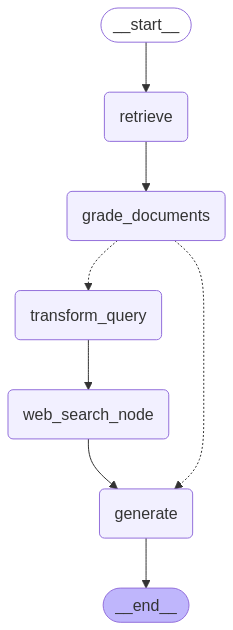

In [77]:
app

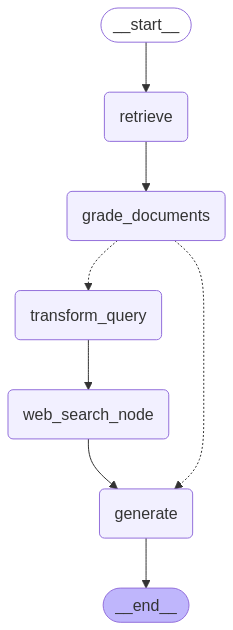

In [78]:
from IPython.display import Image

display(Image(app.get_graph().draw_mermaid_png()))

## LangGraph Agent 실행하기

question을 전달하여 에이전트를 실행합니다.

In [79]:
from pprint import pprint

inputs = {"question": "Attention과 Self-Attetion은 무엇인가요?"}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("---")

print(value["generation"])

---검색---
"Node 'retrieve':"
'---'
---쿼리 연관성 검색---
---GRADE: 관련성 확인---
---GRADE: 관련성 확인---
---GRADE: 관련성 없음---
---GRADE: 관련성 없음---
---GRADE: 관련성 확인---
---평가 결과를 확인합니다---
---DECISION: GENERATE---
"Node 'grade_documents':"
'---'
---생성---
**************DOCUMENTS****************
described in section 3.2.
Self-attention, sometimes called intra-attention is an attention mechanism relating different positions
of a single sequence in order to compute a representation of the sequence. Self-attention has been
used successfully in a variety of tasks including reading comprehension, abstractive summarization,
textual entailment and learning task-independent sentence representations [4, 27, 28, 22].
End-to-end memory networks are based on a recurrent attention mechanism instead of sequence-
aligned recurrence and have been shown to perform well on simple-language question answering and
language modeling tasks [34].
To the best of our knowledge, however, the Transformer is the first transduction mode

In [80]:
inputs = {"question": "Who is Sam Altman?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("---")

print(value["generation"])

---검색---
"Node 'retrieve':"
'---'
---쿼리 연관성 검색---
---GRADE: 관련성 없음---
---GRADE: 관련성 없음---
---GRADE: 관련성 없음---
---GRADE: 관련성 없음---
---GRADE: 관련성 없음---
---평가 결과를 확인합니다---
---DECISION: 지금 Context로 답변 불가---
"Node 'grade_documents':"
'---'
---쿼리 재조합---
BEFORE: Who is Sam Altman?
AFTER: Sam Altman은 누구인가요?
"Node 'transform_query':"
'---'
---WEB SEARCH---
---Query Generation---
Before: Sam Altman은 누구인가요?
After: Query: "Who is Sam Altman?"

page_content='Sam Altman, the CEO of OpenAI. Before leading OpenAI, Sam Altman was the president of Y Combinator, a startup accelerator that has launched companies including Airbnb, Instacart, and Dropbox. Now Altman is leading one of the hottest and most important companies of the moment: OpenAI, which has launched ChatGPT and, most recently, the AI video generator Sora. During OpenAI’s early years, Altman remained Y Combinator’s president and stayed involved from a distance. Altman raised the first billion-dollar investment from Microsoft, which would prov

In [81]:
inputs = {"question": "Decorder가 뭐야?"}
for output in app.stream(inputs):
    for key, value in output.items():

        pprint(f"Node '{key}':")
    pprint("---")


print(value["generation"])

---검색---
"Node 'retrieve':"
'---'
---쿼리 연관성 검색---
---GRADE: 관련성 확인---
---GRADE: 관련성 확인---
---GRADE: 관련성 확인---
---GRADE: 관련성 확인---
---GRADE: 관련성 없음---
---평가 결과를 확인합니다---
---DECISION: GENERATE---
"Node 'grade_documents':"
'---'
---생성---
**************DOCUMENTS****************
respectively.
3.1 Encoder and Decoder Stacks
Encoder: The encoder is composed of a stack of N = 6 identical layers. Each layer has two
sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-
wise fully connected feed-forward network. We employ a residual connection [11] around each of
the two sub-layers, followed by layer normalization [ 1]. That is, the output of each sub-layer is
LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer
itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding
layers, produce outputs of dimension dmodel = 512.
Decoder: The decoder is also composed of a stack

In [82]:
inputs = {"question": "Transformer 모델의 특징이 뭐야?"}
for output in app.stream(inputs):
    for key, value in output.items():

        pprint(f"Node '{key}':")
    pprint("\n---\n")

print(value["generation"])

---검색---
"Node 'retrieve':"
'\n---\n'
---쿼리 연관성 검색---
---GRADE: 관련성 확인---
---GRADE: 관련성 확인---
---GRADE: 관련성 확인---
---GRADE: 관련성 확인---
---GRADE: 관련성 확인---
---평가 결과를 확인합니다---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---생성---
**************DOCUMENTS****************
aligned RNNs or convolution. In the following sections, we will describe the Transformer, motivate
self-attention and discuss its advantages over models such as [17, 18] and [9].
3 Model Architecture
Most competitive neural sequence transduction models have an encoder-decoder structure [5, 2, 35].
Here, the encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence
of continuous representations z = (z1, ..., zn). Given z, the decoder then generates an output
sequence (y1, ..., ym) of symbols one element at a time. At each step the model is auto-regressive
[10], consuming the previously generated symbols as additional input when generating the next.
2
---
Figure 1: The Transformer - 

# 실습) Corrective RAG Scheme 수정하기   

검색 결과 중 irrelevant한 정보가 존재하면, 웹 검색을 통해 이를 보충하도록 flow를 수정해 보세요.   
**Hint**: 웹 검색을 수행하는 조건을 변경하고, 웹 검색을 할 때 기존 문서값을 가져오도록 만들어 보세요.